In [1]:
import matplotlib.pyplot as plt
from methods.ldm.sampler import LDMSampler

c:\Users\dslee\anaconda3\envs\geo_ldm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the sampler
sampler = LDMSampler()

self.X_train.shape: (4000, 4, 128, 128)
self.X_test.shape: (1000, 4, 128, 128)
loading from version 1.8.11


### Unconditional sampling

In [3]:
# unconditional sampling
x_gen = sampler.unconditional_sampling(n_samples=4)  # (b c h w)

sampling loop time step: 100%|██████████| 1000/1000 [00:49<00:00, 20.38it/s]


In [4]:
# postprocess
x_gen = x_gen.cpu()
x_gen = x_gen.argmax(dim=1)  # (b h w)

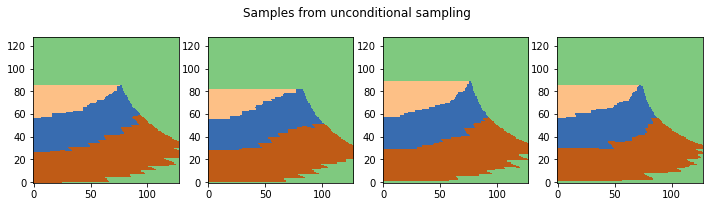

In [5]:
# plot
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
n_channels = sampler.config['dataset']['in_channels']
fig.suptitle('Samples from unconditional sampling')
for i in range(4):
    axes[i].imshow(x_gen[i], vmin=0, vmax=n_channels, cmap='Accent', interpolation='nearest'),
    axes[i].invert_yaxis()
plt.show()

### Conditional sampling

In [25]:
import numpy as np

In [40]:
# get a pair of `x` and `x_cond`, from the test dataset
i = np.random.choice(len(sampler.trainer.ds))
x, x_cond = sampler.trainer.ds[i]  # (c h w), (c+1 h w); +1 for masking

x, x_cond = x.unsqueeze(0), x_cond.unsqueeze(0)  # (1 c h w), (1 c+1 h w)

gpu_idx = sampler.config['trainer_params']['gpu_idx']
x, x_cond = x.to(gpu_idx), x_cond.to(gpu_idx)  # (1 c h w), (1 c+1 h w)

print('x.shape:', x.shape)
print('x_cond.shape:', x_cond.shape)

x.shape: torch.Size([1, 4, 128, 128])
x_cond.shape: torch.Size([1, 5, 128, 128])


In [41]:
# conditional sampling
x_gen = sampler.conditional_sampling(x_cond)

sampling loop time step: 100%|██████████| 1000/1000 [00:44<00:00, 22.31it/s]


In [46]:
# postprocess
x, x_cond = x.cpu().argmax(dim=1), x_cond.cpu().argmax(dim=1)  # (1 h w), (1 h w)
x_gen = x_gen.cpu().argmax(dim=1)  # (1 h w)

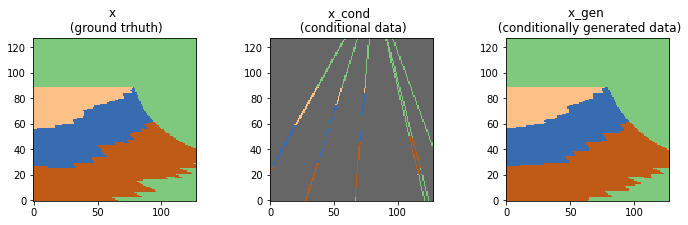

In [56]:
# plot x_cond
fig, axes = plt.subplots(1, 3, figsize=(4*3, 3))

axes[0].set_title('x \n (ground trhuth)')
axes[0].imshow(x[0], vmin=0, vmax=n_channels, cmap='Accent', interpolation='nearest')

axes[1].set_title('x_cond \n (conditional data)')
axes[1].imshow(x_cond[0], vmin=0, vmax=n_channels, cmap='Accent', interpolation='nearest')

axes[2].set_title('x_gen \n (conditionally generated data)')
axes[2].imshow(x_gen[0], vmin=0, vmax=n_channels, cmap='Accent', interpolation='nearest')

for ax in axes.flatten():
    ax.invert_yaxis()
# plt.tight_layout()
plt.show()

If you want to generate multiple samples  (`x_gen`) for `x_cond`, you can expand `x_cond` as shown below and conduct the conditional sampling.

```
x_cond = einops.repeat(x_cond, '1 c h w -> b c h w', b=n_samples)
```